# Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Modelling using LSTM

## Loading Dependencies

In [1]:
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras.losses import BinaryCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT rating, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>10000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 30000) cat_samples, rating, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(rating)
WHERE sentiment != 1
GROUP BY rating
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,mantap,5,2
1,mantaaap !!!!,5,2
2,Belanja nya menyenangkan dengan berbagai benef...,5,2
3,Mantuuul,5,2
4,Ok,5,2


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

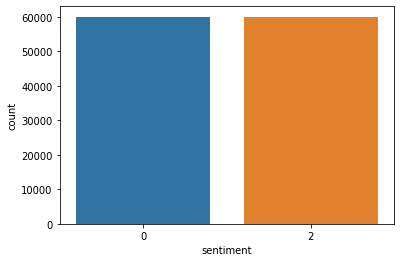

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review       1
rating       0
sentiment    0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119999 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     119999 non-null  object
 1   rating     119999 non-null  int64 
 2   sentiment  119999 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


### Cleaning

In [9]:
class ExtendStopWordRemoverFactory(StopWordRemoverFactory):
  def get_stop_word(self):
    new_sw = ["ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak","bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai","berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama","bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri","diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui","diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan","dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia","ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah","kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu","lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui","melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan","memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan","menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya","pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya","sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus","sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah","seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah","soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba","tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"]
    new_sw.extend(super().get_stop_words())
    return list(set(new_sw))

sw_remover = ExtendStopWordRemoverFactory().create_stop_word_remover()

In [10]:
def preprocessing_text(texts, sw_remover):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = sw_remover.remove(texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts

In [11]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x, sw_remover))

In [12]:
df.head()

,review,rating,sentiment,review_cleaned
0,mantap,5,2,[mantap]
1,mantaaap !!!!,5,2,[mantaaap]
2,Belanja nya menyenangkan dengan berbagai benef...,5,2,"[belanja, menyenangkan, benefit, yg, thanks, all]"
3,Mantuuul,5,2,[mantuuul]
4,Ok,5,2,[ok]


In [13]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,119999.000000
mean,7.419462
std,9.079768
min,0.000000
25%,2.000000
50%,4.000000
75%,10.000000
max,117.000000


word_length    18.0
Name: 0.9, dtype: float64

In [14]:
sentiment_onehot = pd.DataFrame(pd.get_dummies(df['sentiment']))

## 2. LSTM Model

### Tokenize & Padding

In [15]:
tokenizer = Tokenizer(num_words=10000)

In [16]:
tokenizer.fit_on_texts(df['review_cleaned'])
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (119999, 116), X_min: 0, X_max: 9999


In [18]:
y = df['sentiment'].map({0:0, 2:1})

In [19]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(76799, 116) (19200, 116) (24000, 116) (76799,) (19200,) (24000,)


In [20]:
y_train

33056     0
98237     1
82468     0
12163     1
73965     0
         ..
51343     0
24553     1
106087    1
74241     0
111541    1
Name: sentiment, Length: 76799, dtype: int64

### Create Model Layers

In [21]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
2400/2400 [==============================] - 299s 123ms/step - loss: 0.4112 - accuracy: 0.8324 - val_loss: 0.3847 - val_accuracy: 0.8429
Epoch 2/5
2400/2400 [==============================] - 281s 117ms/step - loss: 0.3563 - accuracy: 0.8542 - val_loss: 0.3839 - val_accuracy: 0.8411
Epoch 3/5
2400/2400 [==============================] - 278s 116ms/step - loss: 0.3275 - accuracy: 0.8642 - val_loss: 0.3956 - val_accuracy: 0.8407
Epoch 4/5
2400/2400 [==============================] - 277s 115ms/step - loss: 0.3041 - accuracy: 0.8729 - val_loss: 0.4173 - val_accuracy: 0.8384
Epoch 5/5
2400/2400 [==============================] - 277s 115ms/step - loss: 0.2844 - accuracy: 0.8802 - val_loss: 0.4464 - val_accuracy: 0.8346


<AxesSubplot:>

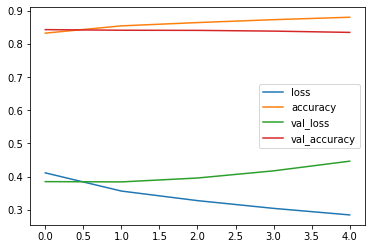

In [23]:
pd.DataFrame(history.history).plot()

### Evaluating Model

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     11994
           1       0.83      0.85      0.84     12006

    accuracy                           0.84     24000
   macro avg       0.84      0.84      0.84     24000
weighted avg       0.84      0.84      0.84     24000



<AxesSubplot:>

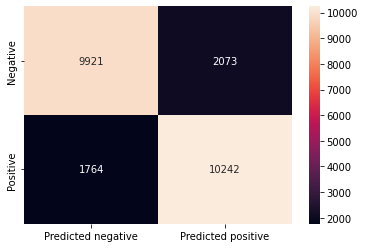

In [24]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])